In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import soundfile
root_path = "F:/DATAS/covid-19-main/dataset-main/"
metafilename = "metadata.json"
#df_f = pd.read_json(root_path + metafilename)

# The metadata.json file contains a description of samples using the following fields:
1. filename - name of the file which is in the directory raw2. 
start_at - the beginning of an induced cough, se
3. 
end_at - end of induced cough, s
4. c
verified - record verified (optional fie
5. d)
asymptomatic - asymptomatic (optional fi
6. ld)
comment - co
7. ment
covid19 - feature of existing C  
8. VID19
source - source of seedf seed

In [5]:

df_f = pd.read_json(root_path + metafilename)
# df_f["asymptomatic"] = df_f["asymptomatic"].fillna(2)
df_f

,filename,verified,asymptomatic,comment,covid19,source,kind
0,60ab9383-73c9-444c-b80f-1e9abeb12449.mp3,1.0,1.0,None,True,call-center,NaN
1,e4589ce5-e477-4018-bfcf-ef64d8176791.mp3,1.0,1.0,None,True,call-center,NaN
2,791bac9e-5193-4870-a335-3573c33359c0.mp3,1.0,1.0,None,True,call-center,NaN
3,377ab53b-c615-4c0f-a891-b679fcf178c0.mp3,1.0,1.0,None,True,call-center,NaN
4,11c11547-a927-413f-a099-b621fd31078f.mp3,1.0,1.0,None,True,call-center,NaN
...,...,...,...,...,...,...,...
1319,2e2a9510-62c8-4755-bfd6-03dac4e462bf.mp3,1.0,0.0,,True,call-center,NaN
1320,d488a61a-ef4a-4782-a2b3-715f3677afd5.mp3,1.0,0.0,,True,call-center,NaN
1321,2fd200ac-86aa-418e-afdc-853cf80d5da6.mp3,1.0,0.0,,True,call-center,NaN
1322,24698944-ca5b-428c-9d84-93fb97bd5651.mp3,1.0,0.0,,True,call-center,NaN


In [6]:
# df_f = df_f.dropna(subset=["verified"])
print("--> shape:", df_f.shape)  # 1324 7
print(df_f.groupby("verified")["filename"].count())  # sum to 1120
print(df_f.groupby("asymptomatic")["filename"].count())  # sum to 674
print(df_f.groupby("covid19")["filename"].count())  # sum to 1324
print(df_f.groupby("source")["filename"].count())  # sum to 1324
print(df_f.groupby("kind")["filename"].count())  # sum to 204

--> shape: (1324, 7)
verified
0.0    738
1.0    382
Name: filename, dtype: int64
asymptomatic
0.0    295
1.0    379
Name: filename, dtype: int64
covid19
False    642
True     682
Name: filename, dtype: int64
source
call-center    700
telegram       624
Name: filename, dtype: int64
kind
входящие       58
другое          5
исх рандом    141
Name: filename, dtype: int64


# 计算每个音频的时长然后保存csv

In [28]:
dura_list = []

# for idx, row in tqdm(enumerate(df_f.iterrows()), total=len(df_f)):
for idx, row in tqdm(enumerate(df_f.itertuples()), total=len(df_f)):
    # print(idx, row)
    fname = root_path + "raw/" +getattr(row, "filename")
    try:
        samples, sample_rate = soundfile.read(fname, dtype='float32')
        duration = samples.shape[0] / float(sample_rate)
        print(sample_rate, end=', ')
        dura_list.append(duration)
    except Exception as e:
        print(e)
        print(fname)
        dura_list.append(99999)
print(dura_list)

 20%|███████████████▍                                                             | 266/1324 [00:00<00:00, 2642.49it/s]

8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000

 40%|██████████████████████████████▉                                              | 531/1324 [00:00<00:00, 2108.57it/s]

8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48

 57%|███████████████████████████████████████████▌                                 | 749/1324 [00:00<00:00, 1222.08it/s]

48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 

 68%|█████████████████████████████████████████████████████▏                        | 902/1324 [00:00<00:00, 959.98it/s]

48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,

 77%|███████████████████████████████████████████████████████████▎                 | 1020/1324 [00:00<00:00, 910.46it/s]

48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000,

100%|████████████████████████████████████████████████████████████████████████████| 1324/1324 [00:01<00:00, 1149.48it/s]

48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 8000, Error opening 'F:/DATAS/covid-19-main/dataset-main/raw/a9e

In [25]:
len(dura_list)

1324

In [26]:
df_f["dura"] = dura_list
df_f.to_csv("F:/DATAS/covid-19-main/dataset-main/covid19-cough_metadata.csv", sep=',')

# 切分音频然后保存csv

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import soundfile
root_path = "F:/DATAS/covid-19-main/dataset-main/"
metafilename = "metadata.json"
df_f = pd.read_json(root_path + metafilename)
m2l = {True:0, False:1}
df_f["covid19"] = df_f["covid19"].apply(lambda x:m2l[x])
print(df_f)
print(df_f.groupby("covid19")["filename"].count())  # sum to 1324

                                      filename  verified  asymptomatic  \
0     60ab9383-73c9-444c-b80f-1e9abeb12449.mp3       1.0           1.0   
1     e4589ce5-e477-4018-bfcf-ef64d8176791.mp3       1.0           1.0   
2     791bac9e-5193-4870-a335-3573c33359c0.mp3       1.0           1.0   
3     377ab53b-c615-4c0f-a891-b679fcf178c0.mp3       1.0           1.0   
4     11c11547-a927-413f-a099-b621fd31078f.mp3       1.0           1.0   
...                                        ...       ...           ...   
1319  2e2a9510-62c8-4755-bfd6-03dac4e462bf.mp3       1.0           0.0   
1320  d488a61a-ef4a-4782-a2b3-715f3677afd5.mp3       1.0           0.0   
1321  2fd200ac-86aa-418e-afdc-853cf80d5da6.mp3       1.0           0.0   
1322  24698944-ca5b-428c-9d84-93fb97bd5651.mp3       1.0           0.0   
1323  963dc32b-fef5-499e-813f-5b11342ac37b.mp3       1.0           0.0   

     comment  covid19       source kind  
0       None        0  call-center  NaN  
1       None        0  call

In [2]:
import librosa
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    #Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power                
    cough_mask = np.array([False]*len(x))
    
    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

In [3]:
HOP_LENGTH = 512        # number of samples between successive frames
WINDOW_LENGTH = 512     # length of the window in samples
N_MEL = 128             # number of Mel bands to generate


def compute_melspectrogram_with_fixed_length(audio, sampling_rate, num_of_samples=128):
    try:
        # compute a mel-scaled spectrogram
        melspectrogram = librosa.feature.melspectrogram(y=audio, 
                                                        sr=sampling_rate, 
                                                        hop_length=HOP_LENGTH,
                                                        win_length=WINDOW_LENGTH, 
                                                        n_mels=N_MEL)

        # convert a power spectrogram to decibel units (log-mel spectrogram)
        melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
        
        melspectrogram_length = melspectrogram_db.shape[1]
        
        # # pad or fix the length of spectrogram 
        # if melspectrogram_length != num_of_samples:
        #     melspectrogram_db = librosa.util.fix_length(melspectrogram_db, 
        #                                                 size=num_of_samples, 
        #                                                 axis=1, 
        #                                                 constant_values=(0, -80.0))
    except Exception as e:
        print("\nError encountered while parsing files\n>>", e)
        return None 
    
    return melspectrogram_db

## 切分咳嗽数据并复制标签

In [6]:
audio_length = 32306
# sample_rate = 22050
all_data = []
all_fname = []
all_sr = []
all_labels = []
new_df = df_f
maxi, mini = 0, 999999
for idx, row in tqdm(enumerate(df_f.itertuples()), total=len(df_f)):
    fname = root_path + "raw/" +getattr(row, "filename")
    label = getattr(row, "covid19")
    # load sound sample
    try:
        audio, sample_rate = librosa.load(fname, mono=True)
    except Exception as e:
        # print(e)
        print("Error file:", fname)
        continue
    maxi = max(maxi, audio.shape[0]/sample_rate)
    mini = min(mini, audio.shape[0]/sample_rate)
    # Segment each audio into individual coughs using a hysteresis comparator on the signal power
    cough_segments, cough_mask = segment_cough(audio, sample_rate, min_cough_len=0.1, cough_padding=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)

    # For each segment, resize to the same length(11025)
    if len(cough_segments) > 0 :
        i = 0
        for audio in cough_segments:
            i+=1
            if len(audio) > 8000:
                if len(audio) < audio_length:
                    audio_pad = librosa.util.pad_center(data=audio, size=audio_length)
                else:
                    audio_pad = audio[:audio_length]
                # audio_pad = audio

            # feature = extract_features(audio_pad, sample_rate)
            #print(len(feature))
            # all_data.append(feature)
            all_data.append(audio_pad)
            all_fname.append(fname)
            all_labels.append(label)
            all_sr.append(sample_rate)
            new_df = pd.concat([new_df, df_f.iloc[[idx], :]], axis=0)
new_df = new_df.iloc[len(df_f):, :]

 34%|██████████████████████████▋                                                   | 453/1324 [00:04<00:07, 118.12it/s]C:\Users\zhaoke\AppData\Local\Temp\ipykernel_12160\4123237431.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(fname, mono=True)
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 36%|████████████████████████████▎                                                 | 480/1324 [00:04<00:07, 115.13it/s]

Error file: F:/DATAS/covid-19-main/dataset-main/raw/098d66e5-bda6-4e99-b787-ab890046c44b.mp3


 94%|████████████████████████████████████████████████████████████████████████▌    | 1248/1324 [00:15<00:00, 136.04it/s]C:\Users\zhaoke\AppData\Local\Temp\ipykernel_12160\4123237431.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(fname, mono=True)
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 96%|██████████████████████████████████████████████████████████████████████████▏  | 1275/1324 [00:15<00:00, 120.50it/s]

Error file: F:/DATAS/covid-19-main/dataset-main/raw/a9ecaf03-40a5-4b43-aaf3-f076f84a69aa.mp3


100%|██████████████████████████████████████████████████████████████████████████████| 1324/1324 [00:15<00:00, 84.51it/s]


In [7]:
print(maxi, mini)
print(len(new_df))
print(len(all_data))

88.98503401360544 0.25700680272108845
2733
2733


In [9]:
# melspects = []
import random
features = []
for i in tqdm(range(len(all_data)),desc="calc.."):
    melspect = compute_melspectrogram_with_fixed_length(all_data[i], all_sr[i])
    # print(melspec.shape)
    # melspects.append(melspect)
    features.append([melspect, all_labels[i], random.randint(1, 10)])


calc..: 100%|█████████████████████████████████████████████████████████████████████| 2733/2733 [00:07<00:00, 342.12it/s]


In [10]:
for mel in features:
    print(mel[0].shape, mel[1], mel[2])
    # melspects[1].shape

(128, 64) 0 6
(128, 64) 0 4
(128, 64) 0 2
(128, 64) 0 5
(128, 64) 0 8
(128, 64) 0 6
(128, 64) 0 6
(128, 64) 0 6
(128, 64) 0 6
(128, 64) 0 2
(128, 64) 0 3
(128, 64) 0 4
(128, 64) 0 8
(128, 64) 0 7
(128, 64) 0 5
(128, 64) 0 3
(128, 64) 0 9
(128, 64) 0 6
(128, 64) 0 7
(128, 64) 0 10
(128, 64) 0 5
(128, 64) 0 3
(128, 64) 0 2
(128, 64) 0 1
(128, 64) 0 5
(128, 64) 0 7
(128, 64) 0 2
(128, 64) 0 4
(128, 64) 0 4
(128, 64) 0 9
(128, 64) 0 5
(128, 64) 0 4
(128, 64) 0 1
(128, 64) 0 9
(128, 64) 0 3
(128, 64) 0 9
(128, 64) 0 8
(128, 64) 0 10
(128, 64) 0 7
(128, 64) 0 5
(128, 64) 0 10
(128, 64) 0 1
(128, 64) 0 7
(128, 64) 0 10
(128, 64) 0 5
(128, 64) 0 3
(128, 64) 0 6
(128, 64) 0 9
(128, 64) 0 9
(128, 64) 0 4
(128, 64) 0 3
(128, 64) 0 5
(128, 64) 0 1
(128, 64) 0 3
(128, 64) 0 7
(128, 64) 0 2
(128, 64) 0 8
(128, 64) 0 1
(128, 64) 0 7
(128, 64) 0 1
(128, 64) 0 4
(128, 64) 0 9
(128, 64) 0 1
(128, 64) 0 8
(128, 64) 0 2
(128, 64) 0 2
(128, 64) 0 8
(128, 64) 0 4
(128, 64) 0 7
(128, 64) 0 4
(128, 64) 0 9
(1

In [11]:
us8k_df = pd.DataFrame(features, columns=["melspectrogram", "label", "fold"])
us8k_df.to_pickle(root_path+"covid19_split_df.pkl")

In [13]:
new_df = new_df.iloc[:, [0,2,4]]
new_df = new_df.reset_index(drop=True)

In [18]:
new_fnames = []
for idx, row in enumerate(new_df.itertuples()):
    new_fnames.append("sound"+("000"+str(idx))[-4:]+'_'+getattr(row,"filename"))
new_fnames

['sound0000_60ab9383-73c9-444c-b80f-1e9abeb12449.mp3',
 'sound0001_60ab9383-73c9-444c-b80f-1e9abeb12449.mp3',
 'sound0002_60ab9383-73c9-444c-b80f-1e9abeb12449.mp3',
 'sound0003_791bac9e-5193-4870-a335-3573c33359c0.mp3',
 'sound0004_377ab53b-c615-4c0f-a891-b679fcf178c0.mp3',
 'sound0005_377ab53b-c615-4c0f-a891-b679fcf178c0.mp3',
 'sound0006_8d61ca2d-2d1a-44cf-8eef-a5e80780daf5.mp3',
 'sound0007_8d61ca2d-2d1a-44cf-8eef-a5e80780daf5.mp3',
 'sound0008_16a541d7-4751-44d8-99d8-4ffc4851f573.mp3',
 'sound0009_73fd5645-ddc0-4307-a488-3991f49a8cb3.mp3',
 'sound0010_1c62f2b5-b10a-4384-97ae-a5971d2feaea.mp3',
 'sound0011_579334f1-ae9e-4afb-b4f7-dc741f44ed3c.mp3',
 'sound0012_e21095a9-beed-4e09-a1e9-b31a67a55dfa.mp3',
 'sound0013_c81f6aed-98a1-4f94-94de-75e57c714ea8.mp3',
 'sound0014_68712daf-4cee-4d8b-b0f4-8ed34fc27454.mp3',
 'sound0015_7a730ff0-9bc5-4ca8-bce4-003706cab80f.mp3',
 'sound0016_a2d80c3f-fc37-4c19-b645-058a8c3b9476.mp3',
 'sound0017_bcd69b35-4fba-43c3-87e6-5343bf4197e2.mp3',
 'sound001

In [19]:
new_df["filename"] = new_fnames
new_df.to_csv(root_path+"covid19_split_df.csv", sep=',')

C:\Users\zhaoke\AppData\Local\Temp\ipykernel_12160\836115574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["filename"] = new_fnames


# End

In [22]:
import numpy as np
mini, maxi = np.floor(min(dura_list)), np.ceil(max(dura_list))
print(mini, maxi)
L = maxi - mini
cnt = [0] * int(L)
for item in dura_list:
    cnt[int(item)] += 1
print(cnt)

0.0 89.0
[113, 645, 252, 125, 79, 37, 22, 11, 9, 7, 5, 1, 0, 3, 0, 0, 2, 0, 1, 1, 5, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


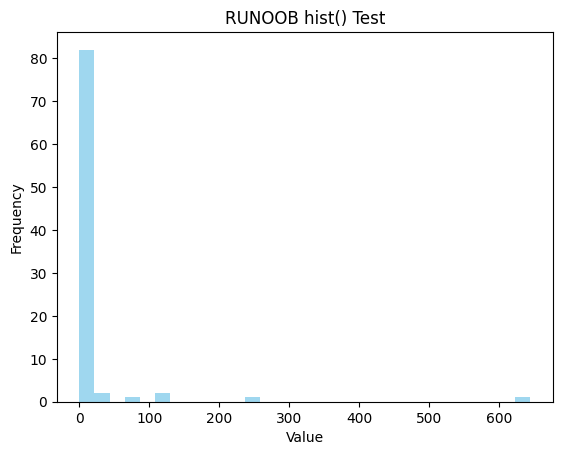

In [23]:
import matplotlib.pyplot as plt
plt.hist(cnt, bins=30, color='skyblue', alpha=0.8)

# 设置图表属性
plt.title('RUNOOB hist() Test')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图表
plt.show()

In [38]:
duras = []
for item in all_data:
    print(item.shape)

(13946,)
(9885,)
(9885,)
(10030,)
(10030,)
(10030,)
(12510,)
(12207,)
(9206,)
(9206,)
(10454,)
(9264,)
(9264,)
(9264,)
(10855,)
(8790,)
(8790,)
(8790,)
(8124,)
(9843,)
(10330,)
(8363,)
(12295,)
(12295,)
(9966,)
(9548,)
(10120,)
(10120,)
(10120,)
(8628,)
(15055,)
(15055,)
(15055,)
(15178,)
(15178,)
(8773,)
(9039,)
(9039,)
(9039,)
(9063,)
(9063,)
(9134,)
(9864,)
(16027,)
(12243,)
(12243,)
(12243,)
(12243,)
(20041,)
(9592,)
(12800,)
(12800,)
(20334,)
(8912,)
(8912,)
(12033,)
(14618,)
(11547,)
(10690,)
(10690,)
(10690,)
(11259,)
(10248,)
(10248,)
(12943,)
(25420,)
(12025,)
(14974,)
(14236,)
(10859,)
(10859,)
(10859,)
(10859,)
(9506,)
(8205,)
(8205,)
(8990,)
(12122,)
(8548,)
(11654,)
(11654,)
(11654,)
(10454,)
(9133,)
(8057,)
(8057,)
(8636,)
(8636,)
(10279,)
(10279,)
(8261,)
(9944,)
(8922,)
(9001,)
(9001,)
(9001,)
(8743,)
(8885,)
(8885,)
(11636,)
(11659,)
(11659,)
(9677,)
(10681,)
(9042,)
(9042,)
(9611,)
(9611,)
(12058,)
(12265,)
(12302,)
(9003,)
(9581,)
(9302,)
(9302,)
(9302,)
(11841,)
(92

In [39]:
print(len(new_df))
print(len(all_data))

2733
2733


(128, 24)